In [211]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from dateutil.parser import parse
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,r2_score,roc_auc_score
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import xgboost as xgb
from treeinterpreter import treeinterpreter as ti
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPRegressor
%matplotlib inline

In [212]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_df = pd.read_csv('sampleSubmission.csv')

In [213]:
train_df.shape

(10886, 12)

(array([ 22.,   1.,   5.,  40., 118., 246., 401., 638., 828., 899., 919.,
        923., 801., 947., 894., 842., 825., 851., 536., 150.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <a list of 20 Patch objects>)

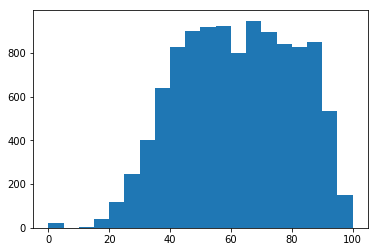

In [214]:
plt.hist(train_df['humidity'],bins=20)

(array([1.313e+03, 0.000e+00, 1.906e+03, 2.177e+03, 1.042e+03, 1.785e+03,
        6.760e+02, 8.640e+02, 2.740e+02, 4.220e+02, 2.000e+02, 8.000e+01,
        8.000e+01, 2.700e+01, 1.100e+01, 2.000e+01, 5.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00]),
 array([ 0.      ,  2.849845,  5.69969 ,  8.549535, 11.39938 , 14.249225,
        17.09907 , 19.948915, 22.79876 , 25.648605, 28.49845 , 31.348295,
        34.19814 , 37.047985, 39.89783 , 42.747675, 45.59752 , 48.447365,
        51.29721 , 54.147055, 56.9969  ]),
 <a list of 20 Patch objects>)

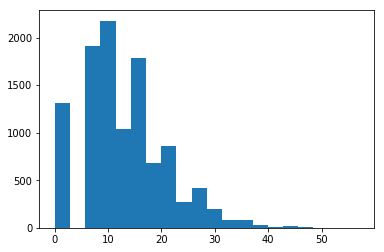

In [215]:
plt.hist(train_df['windspeed'],bins=20)

In [216]:
def normalize(df,col) :
    df[col] = df[col].apply(lambda x : x+1)
    df[col] = np.log(df[col])
    return df
    

In [217]:
train_df = normalize(train_df,'windspeed')
test_df = normalize(test_df,'windspeed')
#train_df[train_df['windspeed'] < 0]
#np.log(1)

(array([1313.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         872., 1034., 1120., 2099.,  961., 1992.,  646.,  533.,  249.,
          61.,    6.]),
 array([0.        , 0.20301948, 0.40603896, 0.60905843, 0.81207791,
        1.01509739, 1.21811687, 1.42113635, 1.62415582, 1.8271753 ,
        2.03019478, 2.23321426, 2.43623374, 2.63925321, 2.84227269,
        3.04529217, 3.24831165, 3.45133113, 3.6543506 , 3.85737008,
        4.06038956]),
 <a list of 20 Patch objects>)

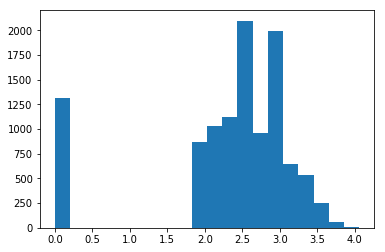

In [218]:
plt.hist(train_df['windspeed'],bins=20)

In [219]:
train_df.corr()['casual']

season        0.096758
holiday       0.043799
workingday   -0.319111
weather      -0.135918
temp          0.467097
atemp         0.462067
humidity     -0.348187
windspeed     0.081882
casual        1.000000
registered    0.497250
count         0.690414
Name: casual, dtype: float64

In [220]:
def get_dates(df) :
    #print df
    datetime = df['datetime'].values
    date_arr = []
    time_arr = []
    year = []
    month = []
    d = []
    for item in datetime :
        dates = item.split(" ")
        date = dates[0]
        time = dates[1].split(':')[0]
        ym = date.split('-')
        year.append(int(ym[0]))
        month.append(int(ym[1]))
        d.append(int(ym[2]))
        date_arr.append(date)
        time_arr.append(int(time))
    

    df['date'] = date_arr
    df['time'] = time_arr
    df['year'] = year
    df['month'] = month
    df['day'] = d
    return df
    #print df['month'].value_counts()
    #print df['day'].value_counts()
    #print df['year'].value_counts()

In [221]:
train_df = get_dates(train_df)
train_df.head()
#get_dates(test_df)
#train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,time,year,month,day
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,0,2011,1,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,1,2011,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2,2011,1,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,3,2011,1,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,4,2011,1,1


In [222]:
test_df = get_dates(test_df)
train_df['day_of_week'] = train_df['date'].apply(lambda x : parse(x).weekday())
test_df['day_of_week'] = test_df['date'].apply(lambda x : parse(x).weekday())

In [223]:
train_df.drop(['datetime','date','day'],axis=1,inplace=True)
test_datetime = test_df['datetime']
test_df.drop(['datetime','date','day'],axis=1,inplace=True)

In [224]:
#time and month require binning
#train_df.groupby('season')['windspeed'].mean().plot(kind='bar')#train_df.corr()['registered'].sort_values()  
#casual = remove weather_4,time_20
#registered = time_11,weather_4,month_12

#1 = spring, 2 = summer, 3 = fall, 4 = winter 
#0.760,32.575 --> spring
#11.365,43.940 --> summer
#12.120,45.455 --> fall
#7.575,34.090 --> winter

train_df['ftemp'] = train_df['temp'] + train_df['atemp']
test_df['ftemp'] = test_df['temp'] + test_df['atemp']
train_df['hot_cold'] = 0
train_df.loc[(train_df['season'] == 2),'hot_cold'] = 1
train_df.loc[(train_df['season'] == 3),'hot_cold'] = 1
test_df['hot_cold'] = 0
test_df.loc[(test_df['season'] == 2) ,'hot_cold'] = 1
test_df.loc[(test_df['season'] == 3) ,'hot_cold'] = 1

maxx = train_df.groupby('hot_cold')['ftemp'].max()
minn = train_df.groupby('hot_cold')['ftemp'].min()
meann = train_df.groupby('hot_cold')['ftemp'].mean()

maxxx = test_df.groupby('hot_cold')['ftemp'].max()
minnn = test_df.groupby('hot_cold')['ftemp'].min()
meannn = test_df.groupby('hot_cold')['ftemp'].mean()

print maxx
train_df['std_temp'] = 5
train_df.loc[train_df['hot_cold'] == 1,'std_temp'] = (train_df.loc[train_df['hot_cold'] == 1,'ftemp'] - meann.values[1]) / (-10)
train_df.loc[train_df['hot_cold'] == 0,'std_temp'] = (train_df.loc[train_df['hot_cold'] == 0,'ftemp'] - meann.values[0]) / (10)


test_df['std_temp'] = 5
test_df.loc[test_df['hot_cold'] == 1,'std_temp'] = (test_df.loc[test_df['hot_cold'] == 1,'ftemp'] - meannn.values[1]) / (-10)
test_df.loc[test_df['hot_cold'] == 0,'std_temp'] = (test_df.loc[train_df['hot_cold'] == 0,'ftemp'] - meannn.values[0]) / (10)

train_df['relative_humidity'] = train_df['humidity']/train_df['ftemp']
test_df['relative_humidity'] = test_df['humidity']/test_df['ftemp']

#train_df.loc

hot_cold
0    63.610
1    84.815
Name: ftemp, dtype: float64


In [225]:
def create_dummies(df,col) :
    dummies = pd.get_dummies(df[col]).rename(columns=lambda x: col + '_' + str(x))
    df = pd.concat([df, dummies], axis=1)
    #print df.head()
    df.drop(col, inplace=True, axis=1)
    #print df.head()
    return df

In [226]:

""""train_df = create_dummies(train_df,'day_of_week')
train_df = create_dummies(train_df,'season')
train_df = create_dummies(train_df,'weather')
train_df = create_dummies(train_df,'time')
train_df = create_dummies(train_df,'year')
train_df = create_dummies(train_df,'month')
test_df = create_dummies(test_df,'day_of_week')
test_df = create_dummies(test_df,'season')
test_df = create_dummies(test_df,'weather')
test_df = create_dummies(test_df,'time')
test_df = create_dummies(test_df,'year')
test_df = create_dummies(test_df,'month')"""
train_df.head()
train_df.drop(['temp','atemp'],axis=1,inplace=True)
test_df.drop(['temp','atemp'],axis=1,inplace=True)
#train_df['humidity_windspeed'] = train_df['humidity'] * train_df['windspeed']
#test_df['humidity_windspeed'] = test_df['humidity'] * test_df['windspeed']
#train_df['ftemp_windspeed'] = train_df['f_temp'] * train_df['windspeed']
#test_df['ftemp_windspeed'] = test_df['f_temp'] * test_df['windspeed']
#train_df.loc['time_category' < 5,'time_category'] = 0

In [227]:
test_df.head()
train_df.drop(['count','hot_cold'],axis=1,inplace=True)
test_df.drop('hot_cold',axis=1,inplace=True)
#train_df.head()
#test_df.columns.values

In [228]:

train_df.head()
#train_df.corr()['registered']

,season,holiday,workingday,weather,humidity,windspeed,casual,registered,time,year,month,day_of_week,ftemp,std_temp,relative_humidity
0,1,0,0,1,81,0.0,3,13,0,2011,1,5,24.235,-0.803893,3.342274
1,1,0,0,1,80,0.0,8,32,1,2011,1,5,22.655,-0.961893,3.531229
2,1,0,0,1,80,0.0,5,27,2,2011,1,5,22.655,-0.961893,3.531229
3,1,0,0,1,75,0.0,3,10,3,2011,1,5,24.235,-0.803893,3.094698
4,1,0,0,1,75,0.0,0,1,4,2011,1,5,24.235,-0.803893,3.094698


In [229]:
train_df_casual_y = train_df['casual']
train_df_casual_x = train_df.drop(['registered','casual'],axis=1)
train_df_registered_y = train_df['registered']
train_df_registered_x = train_df.drop(['registered'],axis=1)

In [230]:

#train_df_registered_x.drop(['time_11','weather_4','month_12'],axis=1,inplace=True)
#test_df_registered = test_df.drop(['time_11','weather_4','month_12'],axis=1)
#train_df_casual_x.drop(['weather_4','time_20'],axis=1,inplace=True)
#test_df_casual = test_df.drop(['weather_4','time_20'],axis=1)

#print train_df_casual_x.columns
#print test_df.columns

In [231]:
#clf_casual = linear_model.LinearRegression()
#clf_casual.fit(train_df_casual_x,train_df_casual_y)
#test_df_casual = clf_casual.predict(test_df)
#clf_registered = linear_model.LinearRegression()
#clf_registered.fit(train_df_registered_x,train_df_registered_y)
#test_df_registered = clf_registered.predict(test_df)

#clf_casual = RandomForestRegressor(n_estimators = 100,oob_score=True)
#clf_casual.fit(train_df_casual_x,train_df_casual_y)
#test_df_casual = clf_casual.predict(test_df)
#clf_registered = RandomForestRegressor(n_estimators=100,oob_score=True)
#clf_registered.fit(train_df_registered_x,train_df_registered_y)
#test_df_registered = clf_registered.predict(test_df)

In [232]:
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 1000, num = 11)]

learning_rate = [0.1,0.2,0.3,0.4,0.5]
min_child_weight = range(1,6,2)
gamma = [i/10.0 for i in range(0,5)]
#bootstrap = [True, False]
subsample =[0.75,0.8,0.85,0.9]
random_grid = {'learning_rate': learning_rate,
               'min_child_weight': min_child_weight ,
               'gamma' : gamma,
               'subsample' : subsample,
               'max_depth' : max_depth
               #'bootstrap' : bootstrap
               }


In [233]:
#rf_casual = XGBRegressor()
#rf_random_casual = RandomizedSearchCV(estimator = rf_casual, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
#rf_random_casual.fit(train_df_casual_x,train_df_casual_y)
#rf_random_casual.best_params_


In [234]:
#rf_registered = XGBRegressor()
#rf_random_registered = RandomizedSearchCV(estimator = rf_registered, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
#rf_random_registered.fit(train_df_registered_x,train_df_registered_y)
#rf_random_registered.best_params_


In [235]:
#clf_casual = RandomForestRegressor(n_estimators = 100,max_depth= 100, min_samples_leaf=1, min_samples_split= 10,bootstrap=True)
#clf_casual.fit(train_df_casual_x,train_df_casual_y)
#test_df_casual, bias, contributions = ti.predict(clf_casual,test_df)
#print cross_val_score(clf_casual,train_df_casual_x,train_df_casual_y)
#print bias
#print contributions
#clf_registered = RandomForestRegressor(max_depth= 100,min_samples_leaf= 1,min_samples_split= 10,n_estimators= 100,bootstrap=True)
#clf_registered.fit(train_df_registered_x,train_df_registered_y)
#test_df_registered, bias, contributions = ti.predict(clf_registered,test_df)
#print cross_val_score(clf_registered,train_df_registered_x,train_df_registered_y)
#print bias
#print contributions

In [236]:
train_df_registered_x.columns
#test_df.head()



Index([u'season', u'holiday', u'workingday', u'weather', u'humidity',
       u'windspeed', u'casual', u'time', u'year', u'month', u'day_of_week',
       u'ftemp', u'std_temp', u'relative_humidity'],
      dtype='object')

In [237]:
#train_data = xgb.DMatrix(train_df_casual_x,label=train_df_casual_y)
#res1 = xgb.cv({'n_estimators':100,'max_depth' : 100,'subsample':0.8,'min_child_weight':3,'gamma':0.3,'eta':0.1,'seed':42},train_data,num_boost_round=100,nfold=3,)
#print res1
reg = XGBRegressor(max_depth=100,subsample=0.8,eta=0.05,gamma=0.3,seed=42,n_estimators=100)
reg.fit(train_df_casual_x,train_df_casual_y)
test_df_casual = reg.predict(test_df)

test_df['casual'] = test_df_casual
test_df = test_df[train_df_registered_x.columns.values]


In [251]:
#train_data = xgb.DMatrix(train_df_registered_x,label=train_df_registered_y)
#res2 = xgb.cv({'n_estimators':500,'max_depth' : 100,'subsample':0.9,'min_child_weight':5,'gamma':0.1,'eta':0.1,'seed':42},train_data,early_stopping_rounds=10, verbose_eval=True,num_boost_round=500,nfold=3)
#print res2
reg = XGBRegressor(max_depth=100,subsample=0.8,gamma=0.3,eta=0.01,seed=42,min_child_weight=5,n_estimators=500)
reg.fit(train_df_registered_x,train_df_registered_y)
test_df_registered = reg.predict(test_df)
print cross_val_score(reg,train_df_casual_x,train_df_casual_y)

[0.6576556  0.74799954 0.81861158]


In [239]:
#reg = MLPRegressor(hidden_layer_sizes=(5,))
#reg.fit(train_df_casual_x,train_df_casual_y)
#test_df_casual = reg.predict(test_df)
#print cross_val_score(reg,train_df_casual_x,train_df_casual_y)
#reg = MLPRegressor(hidden_layer_sizes=(5,))
#reg.fit(train_df_registered_x,train_df_registered_y)
#test_df_registered = reg.predict(test_df)
#print cross_val_score(reg,train_df_casual_x,train_df_casual_y)

In [252]:
count = test_df_casual + test_df_registered
for i in range(0,len(count)) :
    if count[i] < 0 :
        count[i] = 0
count = np.floor(count)

In [241]:
#train_sizes = [1, 100, 500, 2000, 5000, 8708]

#train_sizes, train_scores, validation_scores = learning_curve(shuffle=True,estimator = XGBRegressor(max_depth=500,learning_rate=0.3,subsample=0.75,gamma=0.1), X = train_df_registered_x, y = train_df_registered_y, train_sizes = train_sizes, cv = 5, scoring = 'neg_mean_squared_error')
#print('Training scores:\n\n', train_scores)
#print('\n', '-' * 70) # separator to make the output easy to read
#print('\nValidation scores:\n\n', validation_scores)

In [242]:
#train_scores_mean = -train_scores.mean(axis = 1)
#validation_scores_mean = -validation_scores.mean(axis = 1)

#print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
#print('\n', '-' * 20) # separator
#print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))
#plt.style.use('seaborn')

#plt.plot(train_sizes, train_scores_mean, label = 'Training error')
#plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

#plt.ylabel('MSE', fontsize = 14)
#plt.xlabel('Training set size', fontsize = 14)
#plt.title('Learning curves for a xgboost model', fontsize = 18, y = 1.03)
#plt.legend()
#plt.ylim(0,4000)

In [243]:
#plt.scatter(test_df['f_temp'],test_df_casual,  color='black')
#plt.plot(test_df['f_temp'],test_df_casual, color='blue', linewidth=3)

In [253]:
submission = pd.DataFrame({
        "datetime": test_datetime,
        "count": count
   
    })
submission = submission[['datetime','count']]
submission.head()
submission.to_csv('submission.csv', index=False)